# How to use TA-Lib to generate Alpha Factors

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from talib import RSI, BBANDS, MACD

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

We load the AAPL stock price for the 2007-10 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    data = (store['quandl/wiki/prices']
            .loc[idx['2007':'2010', 'AAPL'],
                 ['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']]
            .unstack('ticker')
            .swaplevel(axis=1)
            .loc[:, 'AAPL']
            .rename(columns=lambda x: x.replace('adj_', '')))

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2007-01-03 to 2010-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1008 non-null   float64
 1   high    1008 non-null   float64
 2   low     1008 non-null   float64
 3   close   1008 non-null   float64
 4   volume  1008 non-null   float64
dtypes: float64(5)
memory usage: 47.2 KB


## Compute Bollinger Bands

In [7]:
up, mid, low = BBANDS(data.close, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

## Compute Relative Strength Index

In [8]:
rsi = RSI(data.close, timeperiod=14)

## Moving Average Convergence/Divergence

The MACD computes the difference between two Exponential Moving Averages (EMA), one longer- and one shorter-term.

The ta-lib MACD Indicator implementation has four inputs:
- the close price
- `fastperiod`: the short-term EMA period
- `slowperiod`: the long-term EMA period
- `signalperiod`: the period for the EMA of the MACD itself

It has three outputs:
- `macd` is the difference between the fast EMA and slow EMA.
- `macdsignal` is the EMA of the MACD value with period `signalperiod`
- `macdhist` computes the difference between `macd` and `macdsignal`

In [9]:
macd, macdsignal, macdhist = MACD(data.close, fastperiod=12, slowperiod=26, signalperiod=9)

AttributeError: 'SubplotSpec' object has no attribute 'rowspan'

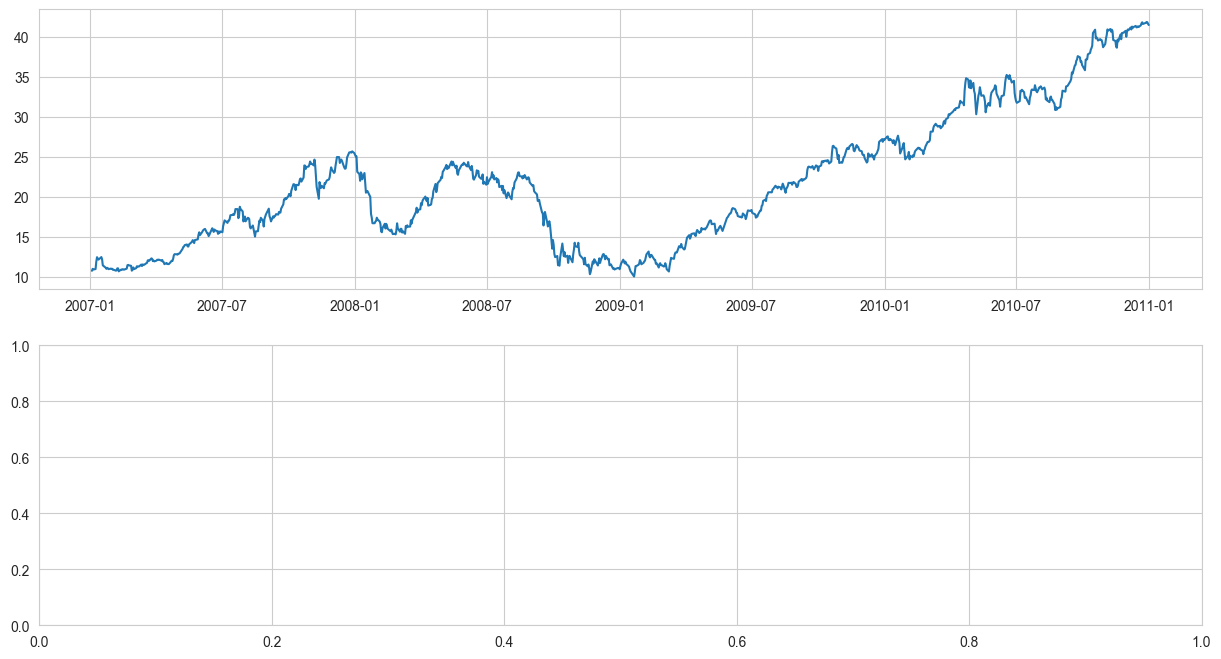

In [10]:
macd_data = pd.DataFrame({'AAPL': data.close, 'MACD': macd, 'MACD Signal': macdsignal, 'MACD History': macdhist})

fig, axes= plt.subplots(nrows=2, figsize=(15, 8))
macd_data.AAPL.plot(ax=axes[0])
macd_data.drop('AAPL', axis=1).plot(ax=axes[1])
fig.tight_layout()
sns.despine();

## Plot Result

In [11]:
data = pd.DataFrame({'AAPL': data.close, 'BB Up': up, 'BB Mid': mid, 'BB down': low, 'RSI': rsi, 'MACD': macd})

AttributeError: 'SubplotSpec' object has no attribute 'rowspan'

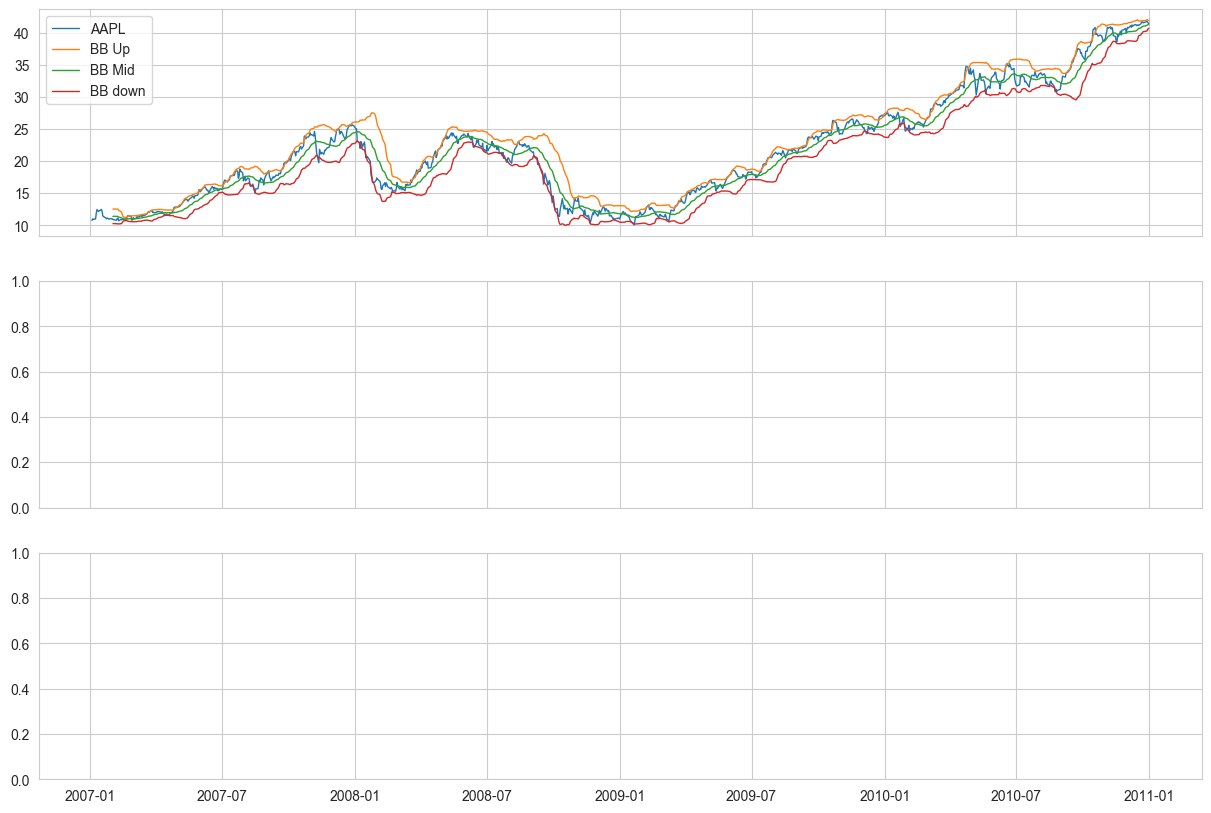

In [12]:
fig, axes= plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
data.drop(['RSI', 'MACD'], axis=1).plot(ax=axes[0], lw=1, title='Bollinger Bands')
data['RSI'].plot(ax=axes[1], lw=1, title='Relative Strength Index')
axes[1].axhline(70, lw=1, ls='--', c='k')
axes[1].axhline(30, lw=1, ls='--', c='k')
data.MACD.plot(ax=axes[2], lw=1, title='Moving Average Convergence/Divergence', rot=0)
axes[2].set_xlabel('')
fig.tight_layout()
sns.despine();